# Image Processor
The goal of this notebook is to create a model that can classify images of the following two classes:
- Kaninchen
- Feldhase

The comments in this notebook are plenty and generated mostly using the help of artificial intelligence. This approach is chosen, as it enables both the developers and the users of this notebook to understand the code better.

# Imports

In [52]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Adjust the GPU memory growth dynamically

In [54]:
gpus = tf.config.experimental.list_physical_devices('GPU') # Get the list of GPUs
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True) # enable tensorflow to allocate memory dynamically -> use only as much GPU memory as needed
gpus

[]

In [55]:
tf.config.list_physical_devices('GPU') # Check if GPU is available

[]

# Load images and transform them into a numpy array

In [68]:
# Create a dataset from the images in the folder (with 400 images per dataset)
data = tf.keras.utils.image_dataset_from_directory('photos', batch_size= 400)

# Create an iterator to iterate over the batches of the dataset (only one batch in our case)
data_iterator = data.as_numpy_iterator()

# Get the first batch (the only one in our case)
images, labels = data_iterator.next()

# First row of pixels of the first image in RGB to show how the data looks like
print(images[0].astype(int)[0])

Found 400 files belonging to 2 classes.
[[32 42 18]
 [33 43 19]
 [34 44 20]
 [35 45 21]
 [35 45 21]
 [37 45 22]
 [37 45 22]
 [37 45 22]
 [38 46 23]
 [43 51 28]
 [42 50 27]
 [43 51 30]
 [42 50 29]
 [38 46 25]
 [38 46 25]
 [37 45 24]
 [37 45 22]
 [38 46 23]
 [42 50 27]
 [40 48 25]
 [39 47 24]
 [40 48 27]
 [38 46 25]
 [36 44 23]
 [32 40 19]
 [28 36 15]
 [25 33 12]
 [22 32  8]
 [21 30  9]
 [23 32 13]
 [19 28  9]
 [18 27 10]
 [14 25  8]
 [12 23  6]
 [13 24  7]
 [13 24  7]
 [13 24  7]
 [12 24  4]
 [13 25  3]
 [14 26  2]
 [16 29  3]
 [18 31  3]
 [22 35  5]
 [23 39  0]
 [26 43  1]
 [29 46  1]
 [33 51  3]
 [36 54  2]
 [39 55  6]
 [41 57  6]
 [43 60  8]
 [42 59  5]
 [43 60  5]
 [46 60  6]
 [47 61  7]
 [48 62  8]
 [46 61  7]
 [46 61  7]
 [46 60  7]
 [45 59 11]
 [44 57 11]
 [43 56 12]
 [41 54 11]
 [39 52  9]
 [41 53 13]
 [40 52 14]
 [39 51 15]
 [42 53 19]
 [46 57 24]
 [49 58 29]
 [49 58 29]
 [52 61 32]
 [54 63 34]
 [56 65 36]
 [53 62 33]
 [58 64 38]
 [58 64 38]
 [58 64 36]
 [55 62 31]
 [54 61 29]


# Inspect the shape of the images

In [69]:
num_images = len(images)
num_classes = len(np.unique(labels))
print(f"Number of images: {num_images}")
print(f"Number of classes: {num_classes}")

Number of images: 400
Number of classes: 2


## Scale the images

This can be done here with /255, as the value range of RGB is only between 0 and 255.

In [70]:
images = images / 255.0 # divide by float forces the result to be a float

# Inspect scaled first row of pixels of the first image in RGB
print(images[0][0])

[[0.12794118 0.16715686 0.07303922]
 [0.13186274 0.17107843 0.07696079]
 [0.13578431 0.175      0.08088236]
 [0.13725491 0.1764706  0.08235294]
 [0.13725491 0.1764706  0.08235294]
 [0.14509805 0.1764706  0.08627451]
 [0.14509805 0.1764706  0.08627451]
 [0.14509805 0.1764706  0.08627451]
 [0.15196079 0.18333334 0.09313726]
 [0.17107843 0.20245098 0.1122549 ]
 [0.16568628 0.19705883 0.10686275]
 [0.16862746 0.2        0.11764706]
 [0.16470589 0.19607843 0.11372549]
 [0.14901961 0.18039216 0.09803922]
 [0.14901961 0.18039216 0.09803922]
 [0.14509805 0.1764706  0.09411765]
 [0.14509805 0.1764706  0.08627451]
 [0.1504902  0.18186274 0.09166667]
 [0.16470589 0.19607843 0.10588235]
 [0.15686275 0.1882353  0.09803922]
 [0.15441176 0.18578431 0.09558824]
 [0.15833333 0.18970588 0.10735294]
 [0.1504902  0.18186274 0.09950981]
 [0.14264706 0.1740196  0.09166667]
 [0.1254902  0.15686275 0.07450981]
 [0.10980392 0.14117648 0.05882353]
 [0.09803922 0.12941177 0.04705882]
 [0.0877451  0.12696078 0.03

# Split the data into train and test data

In [71]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Create the model

In [72]:
# sequential means that the layers are stacked on top of each other leading to a feed forward neural network
model = tf.keras.models.Sequential([
    # Adding a convolutional layer to detect features in the images
    
    # 16 filters to detect 16 different features like edges, textures, structure etc.
    # 3x3 kernel size to detect features in a 3x3 area
    # 1 stride to move the kernel by 1 pixel
    # relu activation function to introduce non-linearity
    # input shape: height, width, colors/channels (RGB)
    tf.keras.layers.Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)), # output shape: 254x254x16 (width, height, features)

    # Adding a batch normalization layer to improve training stability and convergence speed
    tf.keras.layers.BatchNormalization(), # output shape: 254x254x16
    
    # Adding a max pooling layer to reduce the dimensionality of the data
    # achieved by taking the maximum value of a 2x2 area as the representative value for that area
    tf.keras.layers.MaxPool2D(), # output shape: 127x127x16
    
    # Adding more layers to continously learn more complex features
    # Continouse learning of more complex features is achieved by increasing the number of filters
    # A more compact representation of the data is achieved by reducing the kernel size continuously via max pooling
    tf.keras.layers.Conv2D(32, (3, 3), 1, activation='relu'), # output shape: 125x125x32
    tf.keras.layers.BatchNormalization(), # output shape: 125x125x32
    tf.keras.layers.MaxPool2D(), # output shape: 62x62x32
    tf.keras.layers.Conv2D(64, (3, 3), 1, activation='relu'), # output shape: 60x60x64
    tf.keras.layers.BatchNormalization(), # output shape: 60x60x64
    tf.keras.layers.MaxPooling2D(), # output shape: 30x30x64 (width, height, features)
    
    # Adding a flatten layer to transform the 2D data into a 1D vector
    tf.keras.layers.Flatten(), # output shape: 57600
    
    # Adding a dense layer to learn the classification
    tf.keras.layers.Dense(256, activation='relu'),
    
    # Adding the output layer to classify the images - either as a Kaninchen or as a Feldhase
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Configuring the neural network model

In [73]:
# 'compile' configures the selected neural network model
# 'adam' adapts the learning rate of each parameter individually, aiming to minimize the loss function (binary crossentropy in our case)
# the metrics are used to measure the performance of our model
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

# Train the model

In [74]:
# Implementing early stopping to prevent overfitting
# 'patience' is the number of epochs with no improvement after which training will be stopped
# 'restore_best_weights' restores the weights from the epoch with the best value of the monitored quantity
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# 'fit' trains the model
# 'epochs' is the number of times the model is trained on the whole dataset
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, callbacks=[early_stopping])

Epoch 1/20
10/10 [==============================] - 6s 474ms/step - loss: 11.1883 - accuracy: 0.6594 - val_loss: 1.6685 - val_accuracy: 0.5375
Epoch 2/20
10/10 [==============================] - 5s 482ms/step - loss: 1.8741 - accuracy: 0.8281 - val_loss: 4.0758 - val_accuracy: 0.5250
Epoch 3/20
10/10 [==============================] - 5s 465ms/step - loss: 0.4714 - accuracy: 0.9125 - val_loss: 3.6998 - val_accuracy: 0.5250
Epoch 4/20
10/10 [==============================] - 5s 489ms/step - loss: 0.3505 - accuracy: 0.9531 - val_loss: 3.7985 - val_accuracy: 0.6000
Epoch 5/20
10/10 [==============================] - 5s 478ms/step - loss: 0.2680 - accuracy: 0.9656 - val_loss: 4.4608 - val_accuracy: 0.6250
Epoch 6/20
10/10 [==============================] - 5s 508ms/step - loss: 0.0321 - accuracy: 0.9844 - val_loss: 4.7083 - val_accuracy: 0.6125
Epoch 7/20
10/10 [==============================] - 5s 500ms/step - loss: 0.0898 - accuracy: 0.9875 - val_loss: 4.7414 - val_accuracy: 0.6375
Epoch

# Plot the training and the validation accuracy, as well as the loss

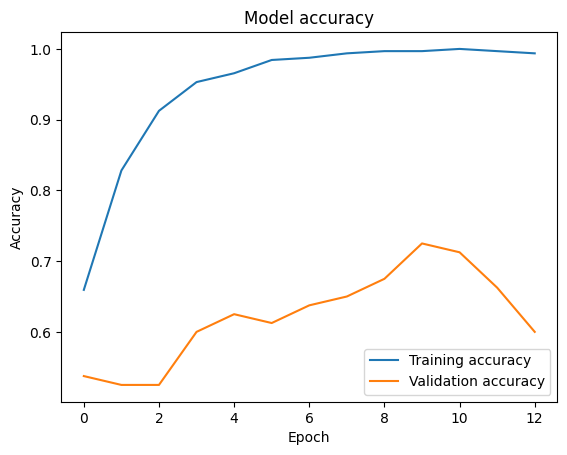

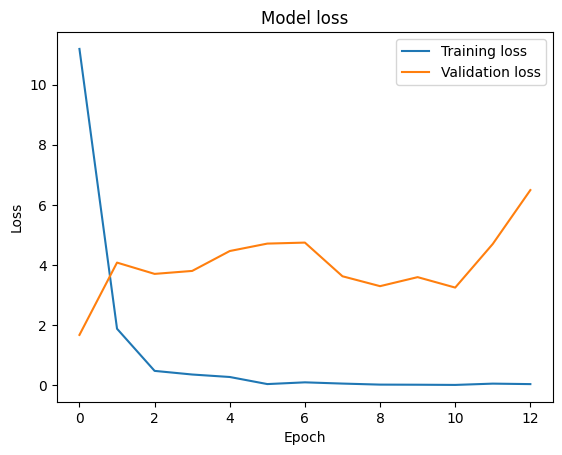

In [75]:
import matplotlib.pyplot as plt

# Plot the training and the validation accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right') # loc='lower right' to place the legend in the lower right corner
plt.show()

# Plot the training and the validation loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training loss', 'Validation loss'], loc='upper right') # loc='upper right' to place the legend in the upper right corner
plt.show()

In [76]:
# Evaluate the model based on the test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2) # verbose=2 to suppress the progress bar
print(f'Test accuracy: {test_acc}')

3/3 - 0s - loss: 3.5915 - accuracy: 0.7250 - 426ms/epoch - 142ms/step
Test accuracy: 0.7250000238418579
